In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import cm
sns.set_style('whitegrid')
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('FAO.csv', encoding='ISO-8859-1')

## Data Transformation & Cleaning

In [4]:
#Pivoting some columns
columns = ['Area Abbreviation', 'Area Code', 'Area', 'Item Code', 'Item','Element Code', 
           'Element', 'Unit', 'latitude', 'longitude']
df = pd.melt(df,id_vars= columns)

In [5]:
# Dropping some columns
df.drop(columns=['Area Code','Item Code','Area Abbreviation','Unit','Element Code'], axis=1,inplace=True)
# Renaming some columns
df.rename(str.lower, axis = 1, inplace = True)
df.rename({'variable':'year','value':'quantity','area':'country'},axis=1,inplace=True)

In [6]:
# Removing the Y from the numbers in df.year
df.year = df.year.str.replace('Y','')

In [7]:
df.head(2)

,country,item,element,latitude,longitude,year,quantity
0,Afghanistan,Wheat and products,Food,33.94,67.71,1961,1928.0
1,Afghanistan,Rice (Milled Equivalent),Food,33.94,67.71,1961,183.0


## Missing Data Evaluation

In [8]:
df_isnull = pd.DataFrame(round((df.isnull().sum().sort_values(ascending=False)/df.shape[0])*100,1)).reset_index()
df_isnull.columns = ['Columns', '% of Missing Data']
df_isnull.style.format({'% of Missing Data': lambda x:'{:.1%}'.format(abs(x))})
cm = sns.light_palette("skyblue", as_cmap=True)
df_isnull = df_isnull.style.background_gradient(cmap=cm)
print('Only the quantity column has a 10.3% missing data')
df_isnull

Only the quantity column has a 10.3% missing data


,Columns,% of Missing Data
0,quantity,10.3
1,year,0
2,longitude,0
3,latitude,0
4,element,0
5,item,0
6,country,0


In [9]:
df.dropna(inplace=True)

## Element Type Distribution

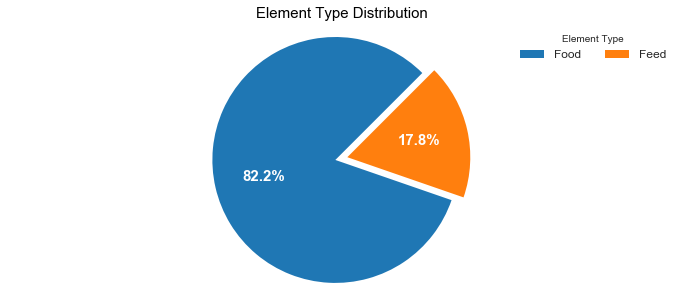

In [38]:
plt.figure(figsize=(12,5))
labels = df.element.value_counts().index
sizes = df.element.value_counts().values
explode = (0.1,0)
plt.pie(sizes, explode=explode,labels=labels,autopct='%1.1f%%', startangle=45,
        wedgeprops = {'linewidth': 1,},textprops ={'color':'white','fontsize':15,'weight':'bold'})
plt.legend(labels,loc='best',ncol=2,fontsize=12,title ='Element Type')
plt.axis('equal')
plt.title('Element Type Distribution',color = 'black',fontsize =15)
plt.show()

In [11]:
df.head(2)

,country,item,element,latitude,longitude,year,quantity
0,Afghanistan,Wheat and products,Food,33.94,67.71,1961,1928.0
1,Afghanistan,Rice (Milled Equivalent),Food,33.94,67.71,1961,183.0


In [12]:
df_feed = df[df.element == 'Feed']

In [13]:
df_feed.item.value_counts().head(10)

Milk - Excluding Butter     9424
Cereals - Excluding Beer    8236
Fish, Seafood               7788
Maize and products          7735
Pelagic Fish                7395
Oilcrops                    6593
Cereals, Other              6463
Starchy Roots               6305
Sorghum and products        6179
Oilcrops, Other             6039
Name: item, dtype: int64

In [14]:
def count_func (input1,input2):
    count_df = pd.DataFrame(input1.value_counts(ascending=False).head(10)).reset_index()
    count_df.columns = ['colname','Values']

    f,ax = plt.subplots(figsize=(10,5))
    count_df.plot(kind = 'barh',ax=ax,color='gray',legend=None,width= 0.8)
    # get_width pulls left or right; get_y pushes up or down
    for i in ax.patches:
        ax.text(i.get_width()+.1, i.get_y()+.40, \
                str(round((i.get_width()), 2)), fontsize=12, color='black',alpha=0.8)  
    #Set ylabel
    ax.set_yticklabels(count_df['colname'])
    # invert for largest on top 
    ax.invert_yaxis()
    kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
    ax.tick_params(**kwargs)
    x_axis = ax.axes.get_xaxis().set_visible(False)
    ax.set_title ('Top 10 '+ input2,color='black',fontsize=16)
    sns.despine(bottom=True)

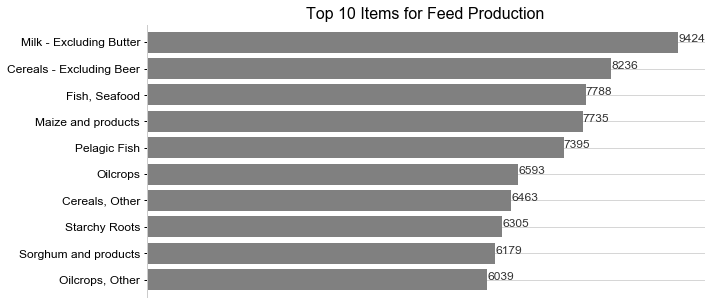

In [15]:
count_func(df_feed.item,'Items for Feed Production')

In [16]:
df_food = df[df.element == 'Food']

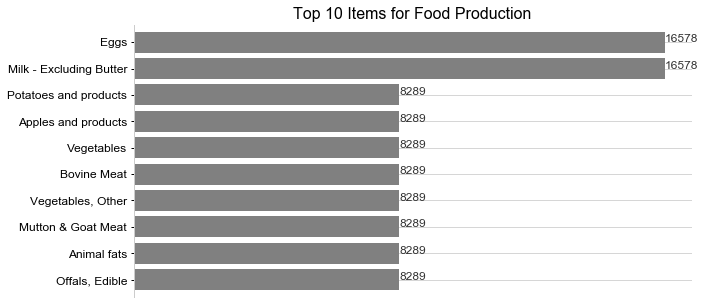

In [17]:
count_func(df_food.item,'Items for Food Production')

In [18]:
df_food.head()

,country,item,element,latitude,longitude,year,quantity
0,Afghanistan,Wheat and products,Food,33.94,67.71,1961,1928.0
1,Afghanistan,Rice (Milled Equivalent),Food,33.94,67.71,1961,183.0
3,Afghanistan,Barley and products,Food,33.94,67.71,1961,237.0
5,Afghanistan,Maize and products,Food,33.94,67.71,1961,403.0
6,Afghanistan,Millet and products,Food,33.94,67.71,1961,17.0


In [19]:
def top_five_year (data):
    d3 = pd.DataFrame(columns = ['year','country','quantity','rank'])
    d1 = data.groupby(['year','country'])['quantity'].sum().reset_index()
    for i in range(1961, 2014):
        d2 = d1[d1.year ==str(i)]
        d2['rank'] = d2['quantity'].rank(ascending = False,method ='first')
        d2['rank'] = d2['rank'].astype(int)
        d2 = d2[d2['rank'].isin([1,2,3,4,5])]
        d4 = pd.concat([d3,d2])
        d3 = d4
    d3.reset_index(drop=True,inplace=True)
    d3.sort_index(by='rank')
    return d3

In [20]:
ed = top_five_year(df_food)

In [21]:
def rank_plot_2(data,text,a,b):
    f,ax = plt.subplots(figsize=(16,5))
    title_list = []
    for i in data.country.value_counts().index[a:b]:
        data[data.country == i].plot(kind='line',x='year',y='rank',ax=ax,label= i,marker='o')
        title_list.append(i)
    ax.set_xticklabels(['0','1961','1971','1981','1991','2001','2011'])
    ax.legend(loc='best',fontsize=12,title ='Country',ncol=1)
    ax.set_title (title_list[0]+ ' & ' + title_list[1]+ ': ' + text +' Production Rank since 1961',
                  color='black',fontsize=16)
    sns.despine()
    plt.tight_layout()
    return plt.show()

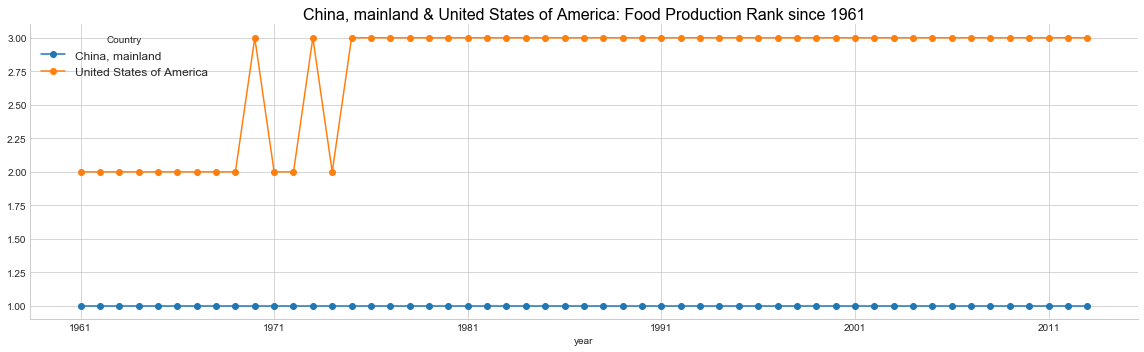

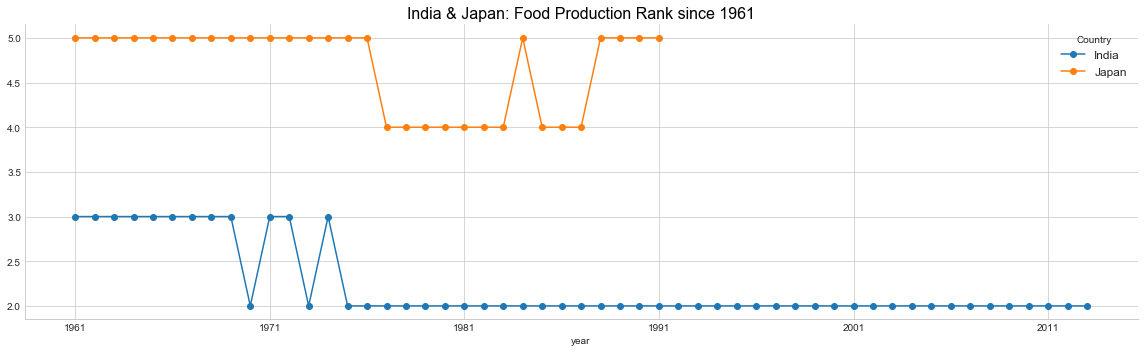

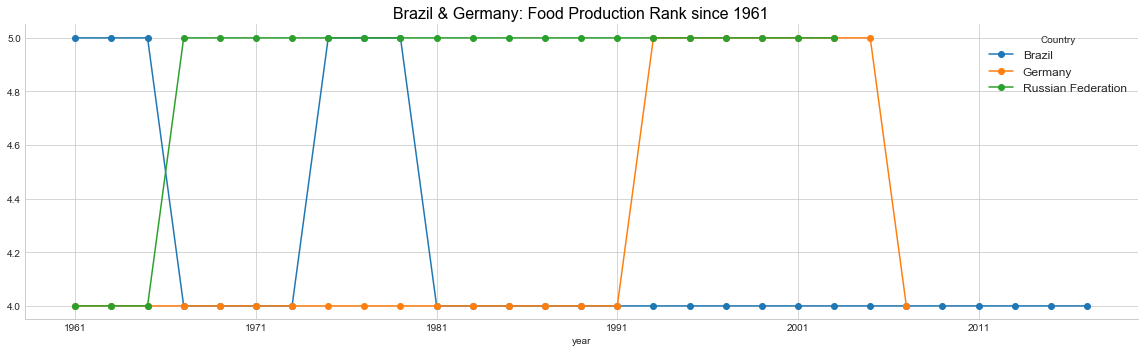

In [22]:
rank_plot_2(ed,'Food',0,2)
rank_plot_2(ed,'Food',2,4)
rank_plot_2(ed,'Food',4,None)

In [23]:
ed_feed = top_five_year(df_feed)

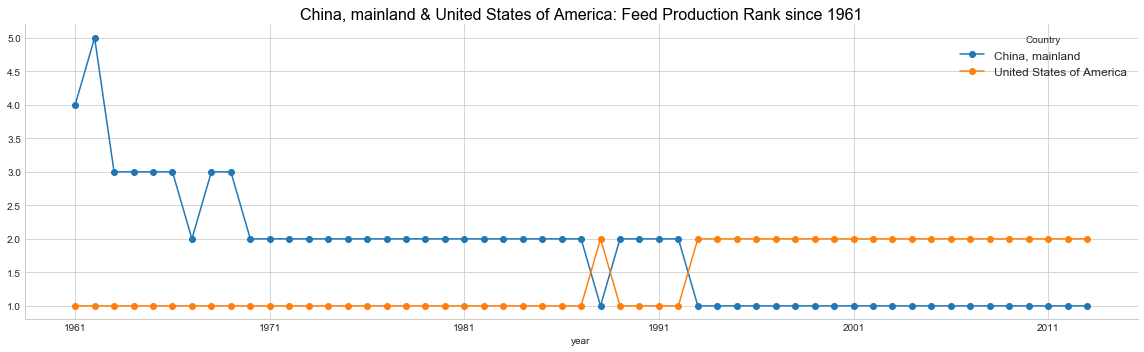

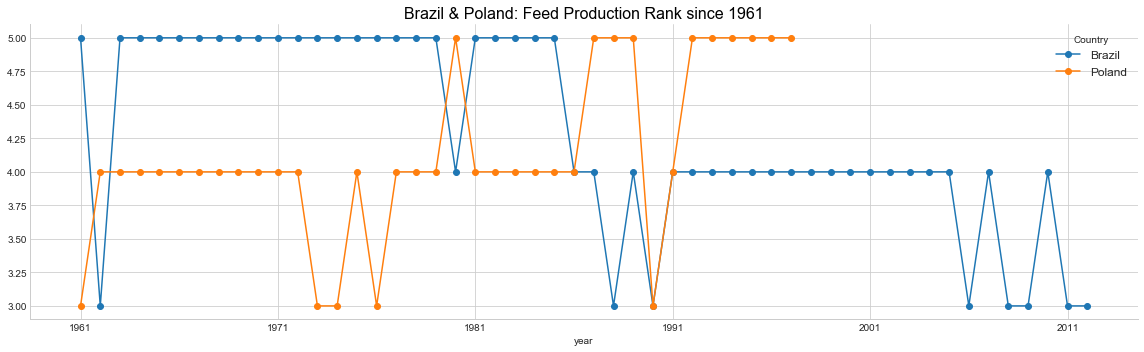

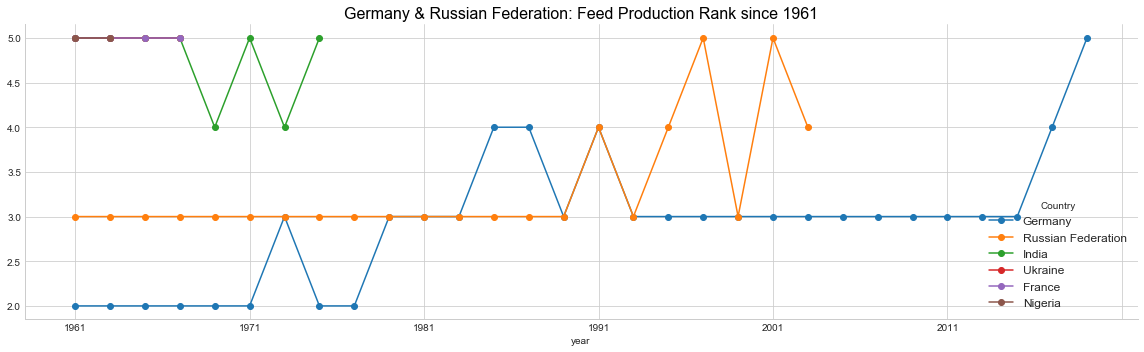

In [24]:
rank_plot_2(ed_feed,'Feed',0,2)
rank_plot_2(ed_feed,'Feed',2,4)
rank_plot_2(ed_feed,'Feed',4,None)

## Top 10 Food & Feed production Countries Over the last 50 Years

In [25]:
def top_food_feed_cty (data1,data2,n_col):

    d1 = data1.groupby('country')['quantity'].sum().reset_index().sort_values(by='quantity',ascending=False)
    d2 = data2.groupby('country')['quantity'].sum().reset_index().sort_values(by='quantity',ascending=False)
    
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,8))
    sns.barplot(x = 'quantity', y = 'country', data= d1.head(n_col),orient='h',
                    palette=['gray','grey','orange','gray','gray'],ax=ax1)
    sns.barplot(x = 'quantity', y = 'country', data= d2.head(n_col),orient='h',
                    palette=['gray','orange','gray','gray','gray'],ax=ax2)
    #top_food_prod.head().plot(kind = 'barh',ax=ax,color='slategray',legend=None,width= 0.8)
    axes = [ax1,ax2]
    d = [d1,d2]
    for j in range(len(axes)):
        for i in axes[j].patches:
            axes[j].text(i.get_width()+120, i.get_y()+.40, \
                str(round(((i.get_width())*100)/d[j].quantity.sum()))+' %', fontsize=14, color='black',alpha=1)  
        #Set ylabel
        #ax.set_yticklabels(top_food_prod.head().country.values)
        # invert for largest on top 
        #ax.invert_yaxis()
        kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':13}
        axes[j].tick_params(**kwargs)
        x_axis = axes[j].axes.get_xaxis().set_visible(False)
        text = ['Food','Feed']
        axes[j].set_title ('Top 5 '+ text[j] +' Production Country for Half a Century',color='black',fontsize=16)
        f.subplots_adjust(wspace=0.22,right=2,hspace=0.4)
        sns.despine(bottom=True)
    return plt.show()

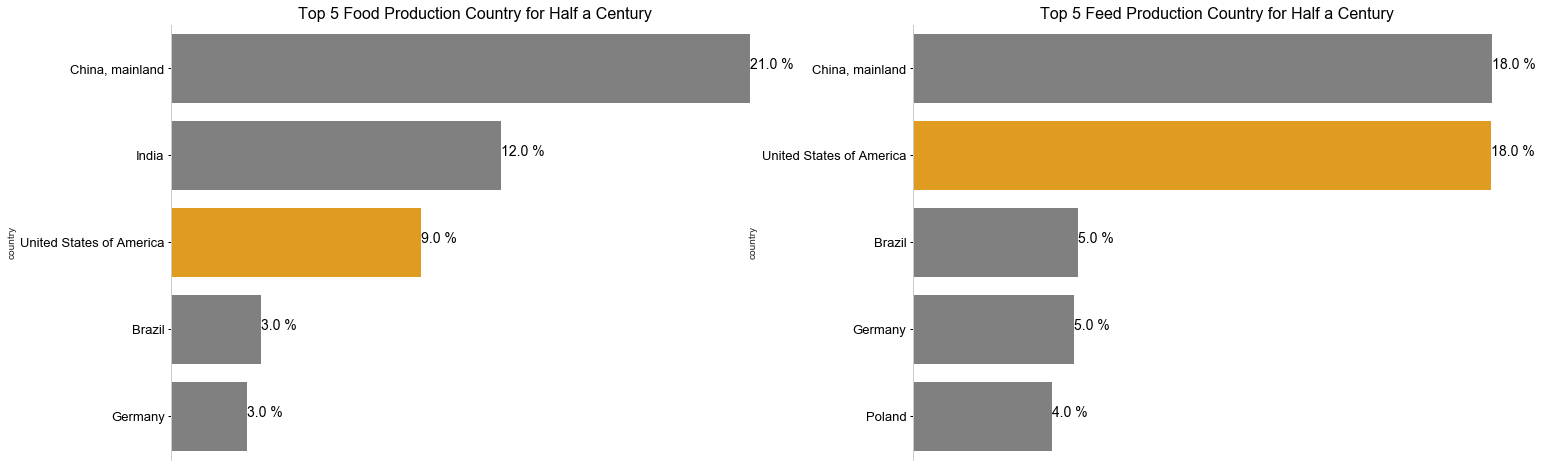

In [26]:
top_food_feed_cty(df_food,df_feed,5)

## Food & Feed Production Growth Rate Since 1961

We will reduce our study to the top 5 country with the highest food or feed production since 1961. This analysis will show how each of the top five country feed or production have grown over the years 

In [27]:
def pct_change (start_pt,current_pt):
    numb = (float(current_pt - start_pt)/start_pt)*100.00
    numb = round(numb,1)
    return numb

In [28]:
def pct_top_cnty (data):
    # To extract the top 5 over 50 years
    ds = data.groupby('country')['quantity'].sum().reset_index().sort_values(by='quantity',ascending=False)
    # Reduce the data set to the top 5 
    ff = data.groupby(['year','country'])['quantity'].sum().reset_index()
    ff2 = ff[ff.country.isin(ds.head().country.values)]

    #Calculate the running percentage 
    d3 = pd.DataFrame(columns = ['year','country','quantity','pct'])
    for i in ds.head().country.values:
        d2 = ff2[ff2.country==i].reset_index()
        pct = [pct_change(d2.quantity[0],qty) for qty in d2.quantity]
        d2['pct'] = pct
        d4 = pd.concat([d3,d2])
        d3 = d4
    return d3

In [29]:
def pct_top_cnty_plot(data,text,a,b):
    f,ax = plt.subplots(figsize=(16,7))
    ds = pct_top_cnty(data).groupby('country')['quantity'].sum().reset_index().sort_values(by='quantity',ascending=False)
    title_list = []
    for i in ds.head().country.values[a:b]:
        pct_top_cnty(data)[pct_top_cnty(data).country == i].plot(kind='line',x='year',y='pct',ax=ax,label= i,marker='o')
        title_list.append(i)
    ax.set_xticklabels(['0','1961','1971','1981','1991','2001','2011'])
    ax.legend(loc='best',fontsize=12,title ='Country',ncol=3)
    ax.set_title (title_list[0]+ ' & ' + title_list[1]+ ': ' + text +' Production Growth Rate since 1961',
                  color='black',fontsize=16)
    sns.despine()
    return plt.show()

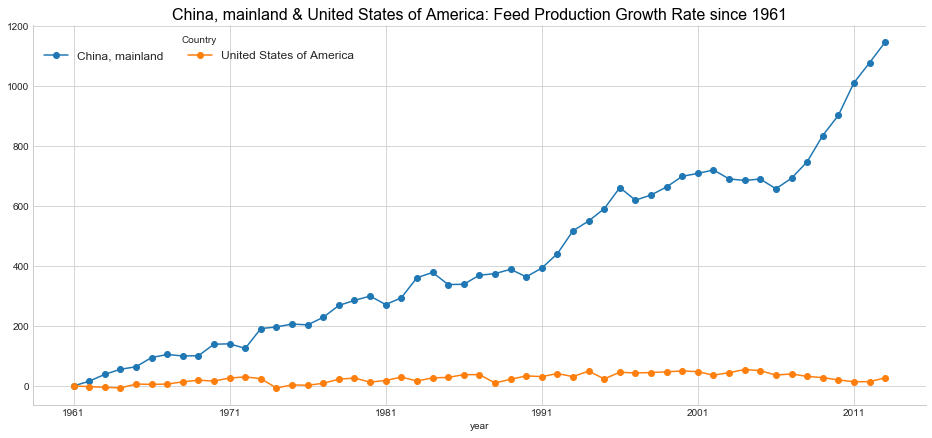

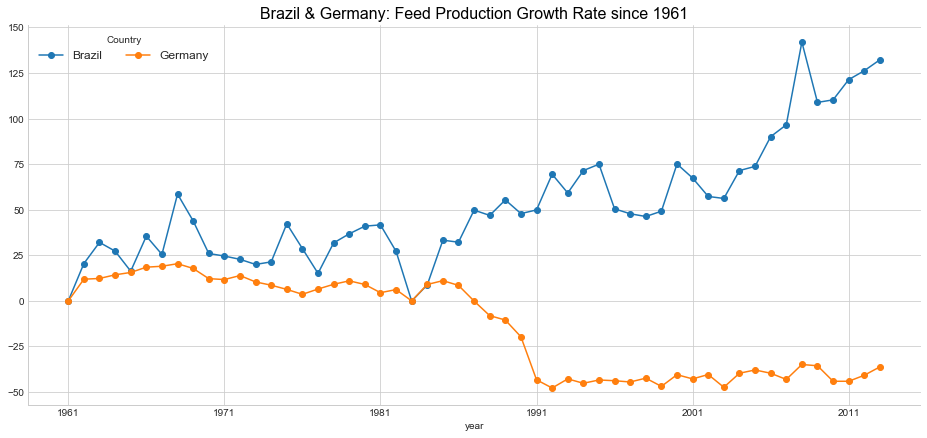

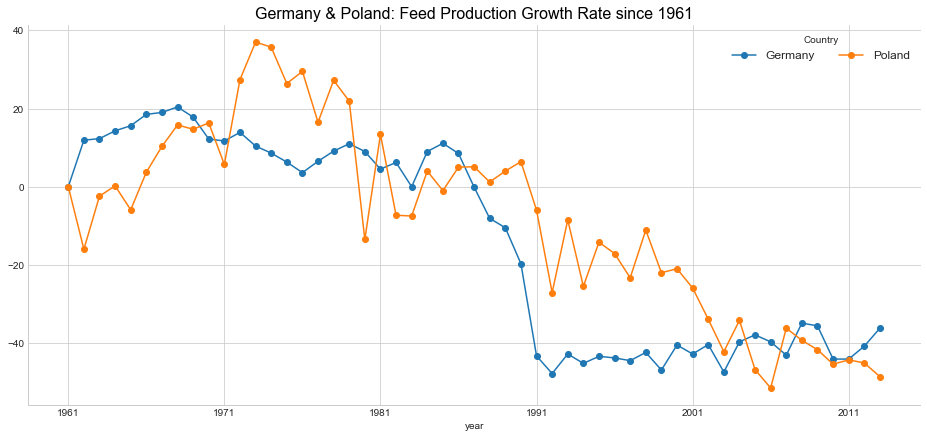

In [30]:
pct_top_cnty_plot(df_feed,'Feed',0,2)
pct_top_cnty_plot(df_feed,'Feed',2,4)
pct_top_cnty_plot(df_feed,'Feed',3,5)

### Comment : Feed Prodcution Analysis
1. Figure 1: Since 1961 the percentage of Feed Production of China has been increasing exponentially whereas as the percentage of Feed Production of the USA is almost Constant over half a Century 
2. Figure 2: Brazil Feed Production percentage since 1961 has been increasing eventhough it tend to flustuate each year
3. Figure 3: Since 1988 the percentage of Feed Production of Germany has consistenly decline compare the Feed Production years of 1961 to 1987. Similarly, Poland Feed Production has been decreasing since around 1978 

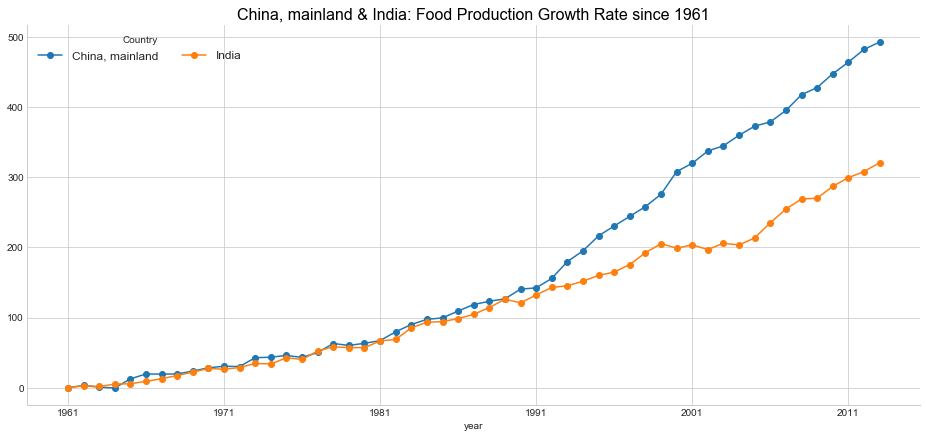

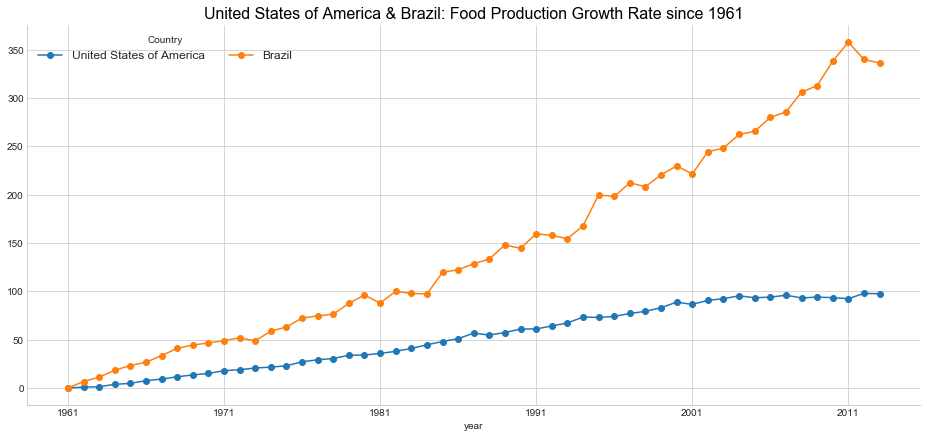

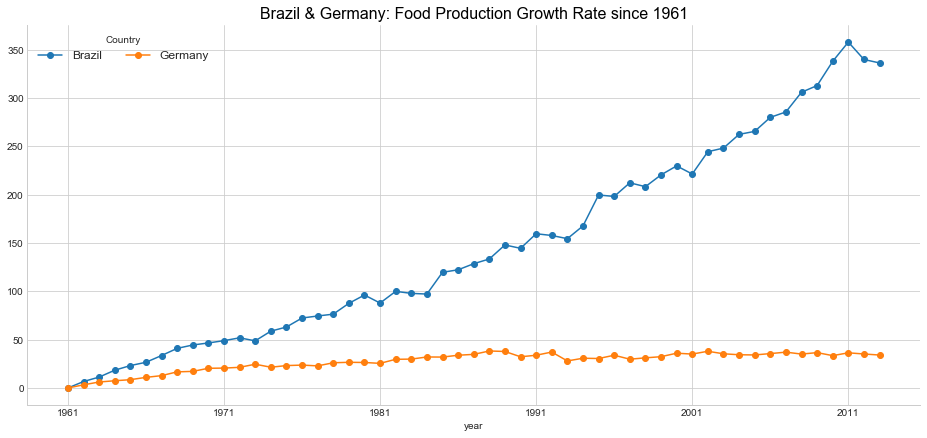

In [31]:
pct_top_cnty_plot(df_food,'Food',0,2)
pct_top_cnty_plot(df_food,'Food',2,4)
pct_top_cnty_plot(df_food,'Food',3,5)

### Comment: Food Analysis
    Figure 1: India and China Food Production growth rate have been approximately the same from  1961 to 1988. But since then, China has surpassed India
    Figure 2: Brazil Food production growth rate has been increased exponentially whereas the USA Food production Growth rate has been increase a a slowly rate
    Figure 3: Germany Food production growth rate seems to have been constantover the years

## Top 5 Country Year Over Year Growth Rate of Food & Feed Production

In [32]:
def pct_top_cnty_2 (data):
    # To extract the top 5 over 50 years
    ds = data.groupby('country')['quantity'].sum().reset_index().sort_values(by='quantity',ascending=False)
    # Reduce the data set to the top 5 
    ff = data.groupby(['year','country'])['quantity'].sum().reset_index()
    ff2 = ff[ff.country.isin(ds.head().country.values)]

    #Calculate the running percentage 
    d3 = pd.DataFrame(columns = ['year','country','quantity','pct'])
    for i in ds.head().country.values:
        d2 = ff2[ff2.country==i].reset_index()
        pct = [int((d2.quantity[qty+1]-d2.quantity[qty])/d2.quantity[qty]*100) for qty in range(len(d2.quantity)-1)]
        pct.insert(0,0) # this is for the first element in the list
        d2['pct'] = pct
        d4 = pd.concat([d3,d2])
        d3 = d4
    return d3

In [33]:
def pct_top_cnty_plot_2(data,text,a,b,col):
    f,ax = plt.subplots(figsize=(16,7))
    ds = pct_top_cnty_2(data).groupby('country')['quantity'].sum().reset_index().sort_values(by='quantity',ascending=False)
    title_list = []
    for i in ds.head().country.values[a:b]:
        pct_top_cnty_2(data)[pct_top_cnty_2(data).country == i].plot(kind='line',x='year',y='pct',ax=ax,label= i,marker='o')
        title_list.append(i)
    ax.set_xticklabels(['0','1961','1971','1981','1991','2001','2011'])
    ax.legend(loc=(0.9,0.85),fontsize=12,title ='Country',ncol=1)
    #ax.set_xlim()
    ax.set_title (title_list[0]+ ' & ' + title_list[1]+': YoY Growth Rate of '+ text +' Production Country since 1961'
                  ,color=col,fontsize=14)
    sns.despine()
    return plt.show()

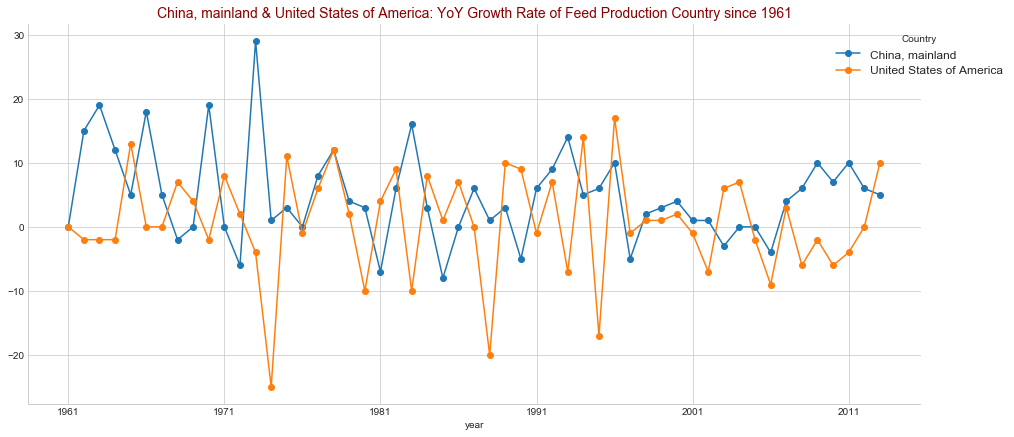

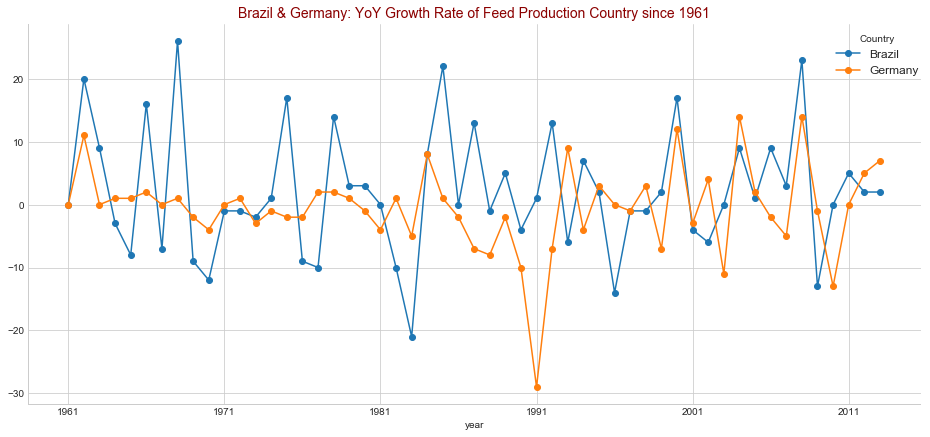

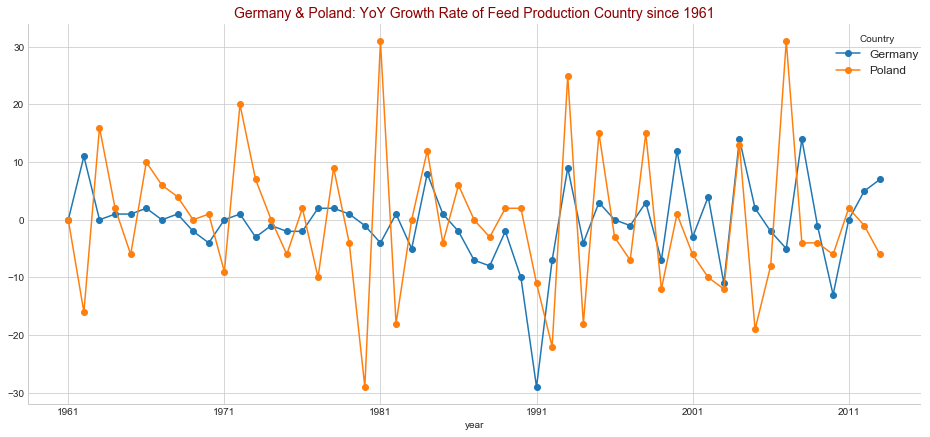

In [34]:
pct_top_cnty_plot_2(df_feed,'Feed',0,2,'darkred')
pct_top_cnty_plot_2(df_feed,'Feed',2,4,'darkred')
pct_top_cnty_plot_2(df_feed,'Feed',3,5,'darkred')

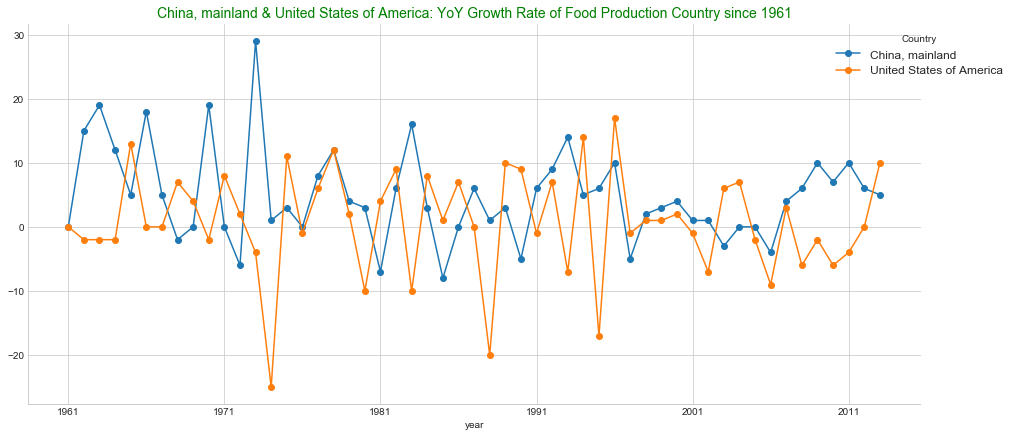

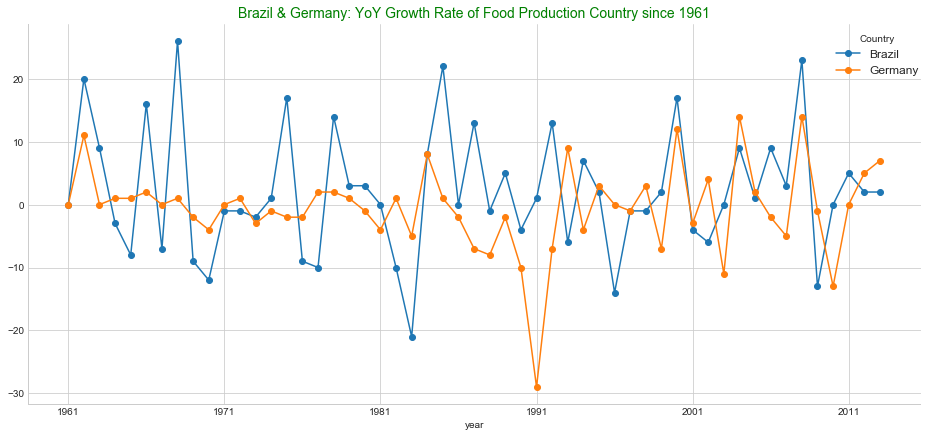

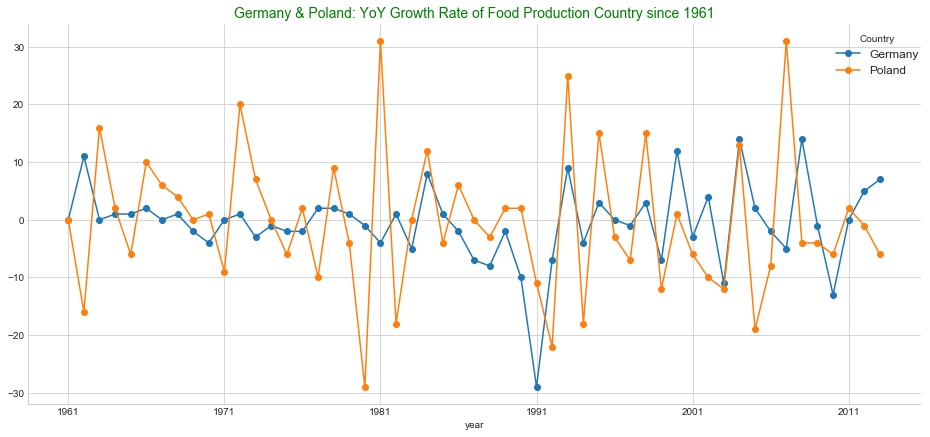

In [35]:
pct_top_cnty_plot_2(df_feed,'Food',0,2,'green')
pct_top_cnty_plot_2(df_feed,'Food',2,4,'green')
pct_top_cnty_plot_2(df_feed,'Food',3,5,'green')